In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  Step 1: Import the necessary  library


In [12]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import joblib

# Step 2: Data Preprocessing

In [14]:
# Load the dataset
df = pd.read_csv("data.csv")
print("Dataset Loaded. Shape:", df.shape)

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

Dataset Loaded. Shape: (39942, 5)

Missing Values:
 label      0
title      0
text       0
subject    0
date       0
dtype: int64


In [15]:
# Text Preprocessing Function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [16]:
# Apply text cleaning to the "text" column
df['clean_text'] = df['text'].map(clean_text)


# Confirm cleaning worked
print("\nSample cleaned text:\n", df['clean_text'].head())




Sample cleaned text:
 0    washington reuters the head of a conservative ...
1    washington reuters transgender people will be ...
2    washington reuters the special counsel investi...
3    washington reuters trump campaign adviser geor...
4    seattle washington reuters president donald tr...
Name: clean_text, dtype: object


In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Step 3: Model Training

In [18]:
# Split the dataset (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

print("Training Set Size:", len(X_train))
print("Testing Set Size:", len(X_test))

custom_stopwords = list(set(stopwords.words('english')))
# Apply TF-IDF (Limit to 5000 most important words)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=custom_stopwords)
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

words = np.array(tfidf_vectorizer.get_feature_names_out())
print("TF-IDF Shape:", X_tfidf.shape)


# Fit TF-IDF only on training data & transform both train & test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nTF-IDF Applied:")
print("Train Shape:", X_train_tfidf.shape)
print("Test Shape:", X_test_tfidf.shape)

# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_tfidf.toarray().astype(np.float64)
X_test_dense = X_test_tfidf.toarray().astype(np.float64)

# Convert labels to NumPy array
y_train = np.array(y_train)
y_test = np.array(y_test)

# Confirm everything is correctly formatted
print("\nData Types & Shapes:")
print("Train Data Type:", type(X_train_dense))
print("Train Data Shape:", X_train_dense.shape)
print("Test Data Type:", type(X_test_dense))
print("Test Data Shape:", X_test_dense.shape)


Training Set Size: 31953
Testing Set Size: 7989
TF-IDF Shape: (39942, 5000)

TF-IDF Applied:
Train Shape: (31953, 5000)
Test Shape: (7989, 5000)

Data Types & Shapes:
Train Data Type: <class 'numpy.ndarray'>
Train Data Shape: (31953, 5000)
Test Data Type: <class 'numpy.ndarray'>
Test Data Shape: (7989, 5000)


In [19]:

# Train the Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42)
rf_model.fit(X_train_dense, y_train)

print(" Random Forest Model Trained Successfully!")

 Random Forest Model Trained Successfully!


#  Step 4: Evaluate the Model


In [20]:

# Make Predictions
y_pred_rf = rf_model.predict(X_test_dense)

# Evaluate the Model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"\n Random Forest Accuracy: {accuracy_rf:.4f}")
print("\n📊 Classification Report:\n", report_rf)


 Random Forest Accuracy: 0.9821

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3996
           1       0.97      0.99      0.98      3993

    accuracy                           0.98      7989
   macro avg       0.98      0.98      0.98      7989
weighted avg       0.98      0.98      0.98      7989



In [21]:
# Get accuracy on training data
y_train_pred_rf = rf_model.predict(X_train_dense)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)

print(f" Training Accuracy: {train_accuracy_rf:.4f}")
print(f" Testing Accuracy: {accuracy_rf:.4f}")  # From previous step


 Training Accuracy: 0.9864
 Testing Accuracy: 0.9821


In [22]:
# Get feature importance
feature_importance = rf_model.feature_importances_

# Get top 10 most important words
top_n = 10
indices = np.argsort(feature_importance)[-top_n:]
top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in indices]

print("🔹 Top 10 Most Important Words for Classification:")
print(top_words)


🔹 Top 10 Most Important Words for Classification:
['know', 'video', 'watch', 'getty', 'image', 'washington', 'featured', 'said', 'via', 'reuters']


In [23]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X_train_dense, y_train, cv=5)
print(f"✅ Cross-validation Accuracy:,  {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

✅ Cross-validation Accuracy:,  0.9795 ± 0.0010


# Some Graphs present our Results

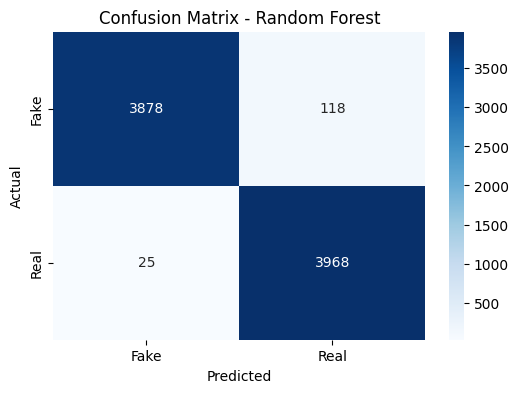

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

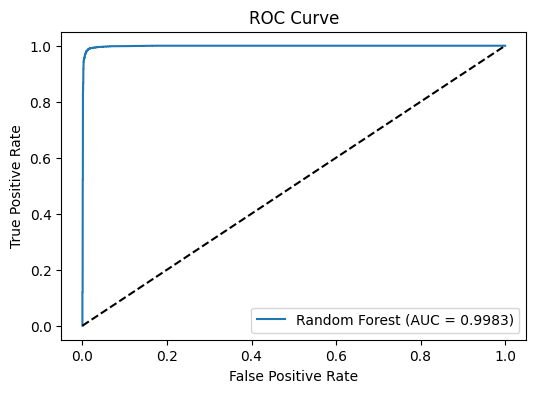

In [25]:
# Get probabilities
y_probs_rf = rf_model.predict_proba(X_test_dense)[:,1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs_rf)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

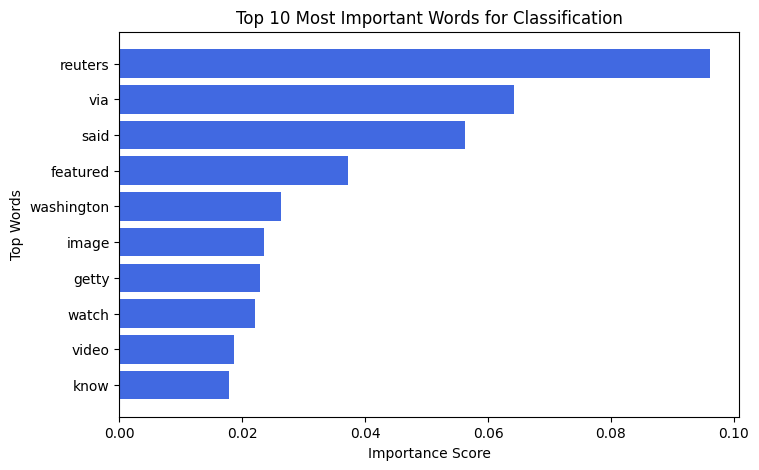

In [32]:
# Get feature importance
feature_importance = rf_model.feature_importances_

# Get top 10 most important words
top_n = 10
indices = np.argsort(feature_importance)[-top_n:]
top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in indices]
top_values = feature_importance[indices]

# Plot feature importance
plt.figure(figsize=(8,5))
plt.barh(top_words, top_values, color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Top Words')
plt.title('Top 10 Most Important Words for Classification')
plt.show()

# comparison between Random Forest and SVM and Naïve Bayes

In [3]:
# Load trained models
nb_model = joblib.load("naive_bayes_model.pkl")
rf_model = joblib.load("random_forest_model.pkl")
svm_model = joblib.load("svm_model.pkl")

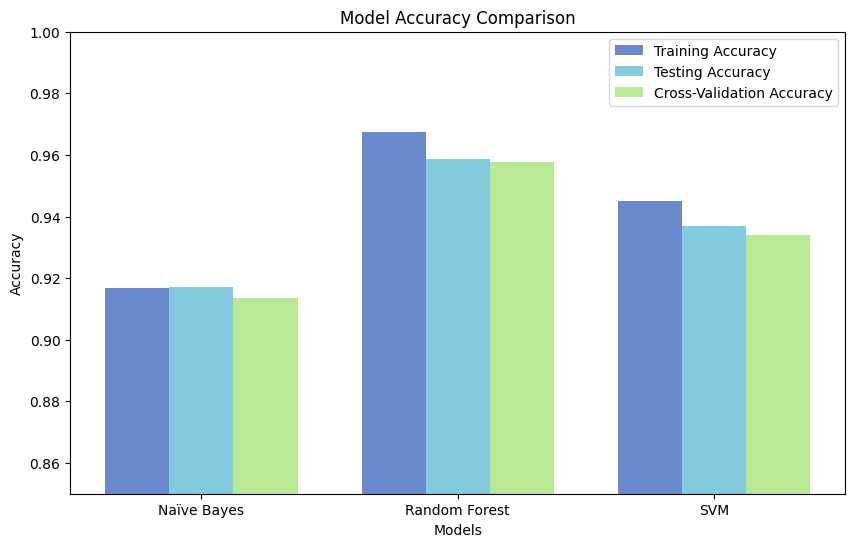

In [5]:
models = ["Naïve Bayes", "Random Forest", "SVM"]
training_accuracy = [0.9168, 0.9675, 0.945]  # Replace with actual SVM training accuracy
testing_accuracy = [0.9171, 0.9588, 0.937]   # Replace with actual SVM testing accuracy
cv_accuracy = [0.9136, 0.9577, 0.934]       # Replace with actual SVM cross-validation accuracy

# Bar Width
bar_width = 0.25
x_indexes = np.arange(len(models))

# Create Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(x_indexes, training_accuracy, width=bar_width, label="Training Accuracy", color='#6a89cc')
plt.bar(x_indexes + bar_width, testing_accuracy, width=bar_width, label="Testing Accuracy", color='#82ccdd')
plt.bar(x_indexes + 2 * bar_width, cv_accuracy, width=bar_width, label="Cross-Validation Accuracy", color='#b8e994')

# Labels & Legends
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(ticks=x_indexes + bar_width, labels=models)
plt.legend()
plt.ylim(0.85, 1.0)
# Show Plot
plt.show()

# Step 5: Predict on validation_data.csv

## Load and Preprocess the the validation dataset

In [77]:
# Load the validation dataset
df_validation = pd.read_csv("validation_data_randomForest.csv")

In [78]:
# Preprocess the text (same cleaning function)
df_validation['clean_text'] = df_validation['text'].map(clean_text)

# Transform text using the trained TF-IDF vectorizer
X_validation_tfidf = tfidf_vectorizer.transform(df_validation['clean_text'])

# Step 6: Predict labels using the trained model

In [80]:
df_validation['label'] = rf_model.predict(X_validation_tfidf)
# Ensure label "2" is replaced with "0" or "1"
df_validation['label'] = df_validation['label'].replace(2, 0)  # Just in case

# Step 7: Save the updated validation file

In [81]:
df_validation.to_csv("validation_data_RandomForest.csv", index=False)

print(" Predictions saved to validation_data_RandomForest.csv")

 Predictions saved to validation_data_RandomForest.csv
